Membros do grupo:
- Olavo Ferraz (ofn@cesar.school)
- Victor Souza (vrss@cesar.school)

Dataset Escolhido: https://www.kaggle.com/datasets/juniorbueno/neural-networks-homer-and-bart-classification

Carregamento do conjunto de dados

In [ ]:
import kagglehub

path = kagglehub.dataset_download("juniorbueno/neural-networks-homer-and-bart-classification")

100%|██████████| 8.06M/8.06M [00:00<00:00, 10.6MB/s]

Extracting files...


## Importação das bibliotecas

In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import kagglehub
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import WeightedRandomSampler

In [ ]:
# http://pytorch.org/
from os.path import exists

import torch

In [ ]:
import os
image_paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.bmp'):
            image_paths.append(os.path.join(root, file))

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Loop para carregar e exibir as imagens
'''for img_path in image_paths:
    # Carrega a imagem usando PIL
    img = Image.open(img_path)

    # Exibe a imagem com Matplotlib
    plt.imshow(img)
    plt.title(f"Imagem: {img_path.split('/')[-1]}")  # Nome do arquivo como título
    plt.axis('off')  # Remove os eixos
    plt.show()'''


'for img_path in image_paths:\n    # Carrega a imagem usando PIL\n    img = Image.open(img_path)\n\n    # Exibe a imagem com Matplotlib\n    plt.imshow(img)\n    plt.title(f"Imagem: {img_path.split(\'/\')[-1]}")  # Nome do arquivo como título\n    plt.axis(\'off\')  # Remove os eixos\n    plt.show()'

# Treinamento com interface de alto nível

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.labels = self.get_labels()

    def get_labels(self):
      labels = []
      for path in self.image_paths:
          if "bart" in os.path.basename(path).lower():
              labels.append(0)  # Bart
          elif "homer" in os.path.basename(path).lower():
              labels.append(1)  # Homer
          else:
              # Caso a imagem não tenha nem "bart" nem "homer", exibe mensagem de erro
              print(f"Imagem sem classe identificada: {path}")
              raise ValueError(f'Imagem sem classe identificada: {path}')
      return labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
# Configuração do dispositivo
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Transformações para as imagens
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.RandomCrop(64, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Contagem das amostras das classes "Bart" e "Homer"
bart_count = len([path for path in image_paths if 'bart' in path.lower()])
homer_count = len([path for path in image_paths if 'homer' in path.lower()])

print(f"Numero de imagens do Bart: {bart_count}")
print(f"Numero de imagens do Homer: {homer_count}")

if bart_count == 0 or homer_count == 0:
    raise ValueError("Uma das classes não possui amostras suficientes!")

# Contagem geral das classes
class_counts = [bart_count, homer_count]

# Calcular pesos das classes
total_count = sum(class_counts)
class_weights = torch.tensor([total_count / count for count in class_counts])

# Verifique os pesos das classes
print(f'Pesos das classes: {class_weights}')

# Definir a função de perda com pesos de classe
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Dividir os dados em treino e teste
split_idx = int(0.8 * len(image_paths))
train_paths = image_paths[:split_idx]
test_paths = image_paths[split_idx:]

# Dataset e DataLoader
train_dataset = CustomDataset(train_paths, transform=transform)
test_dataset = CustomDataset(test_paths, transform=transform)

# Calcular os pesos das amostras para o WeightedRandomSampler
targets = [target for _, target in train_dataset]
class_sample_counts = [sum([1 for t in targets if t == i]) for i in range(2)]  # Supondo 2 classes
weights = [sum(class_sample_counts) / class_sample_counts[t] for t in targets]

# Criar o WeightedRandomSampler
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# DataLoader com sampler para balancear as classes
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f'Dataloaders configurados com sucesso!')

Numero de imagens do Bart: 269
Numero de imagens do Homer: 269
Pesos das classes: tensor([2., 2.])
Dataloaders configurados com sucesso!


## Criação da rede

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

## Treinamento

### Criando o objeto de treinamento

In [ ]:
def train(log_interval, dry_run, model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_fn(output, target)
        optimizer.zero_grad()
        #loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    accuracy = 100. * correct / total
    print(f'Epoch {epoch}, Loss: {running_loss/len(train_loader.dataset):.4f}, Accuracy: {accuracy:.2f}%')



In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bart', 'Homer'], yticklabels=['Bart', 'Homer'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def test_with_metrics(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    plot_confusion_matrix(y_true, y_pred)
    return accuracy, test_loss

## Avaliação

Train Epoch: 1 [0/215 (0%)]	Loss: 0.697095
Epoch 1, Loss: 0.0188, Accuracy: 50.23%

Test set: Average loss: 0.6845, Accuracy: 37/54 (69%)



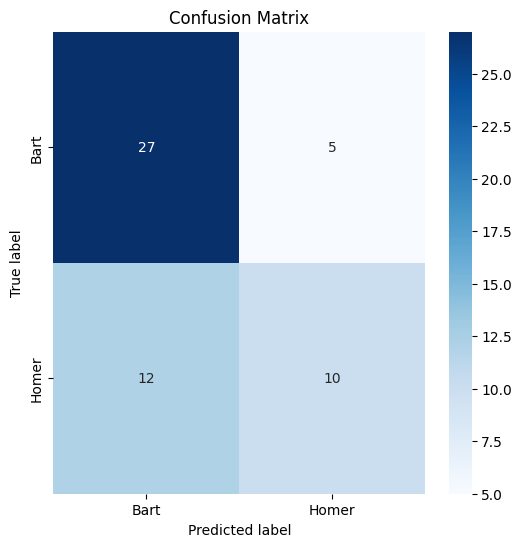

Train Epoch: 2 [0/215 (0%)]	Loss: 0.990044
Epoch 2, Loss: 0.0184, Accuracy: 62.79%

Test set: Average loss: 1.0484, Accuracy: 27/54 (50%)



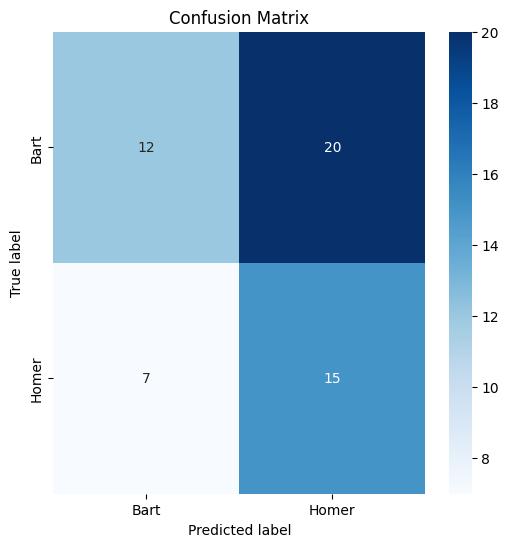

Train Epoch: 3 [0/215 (0%)]	Loss: 0.883952
Epoch 3, Loss: 0.0151, Accuracy: 60.93%

Test set: Average loss: 0.9510, Accuracy: 31/54 (57%)



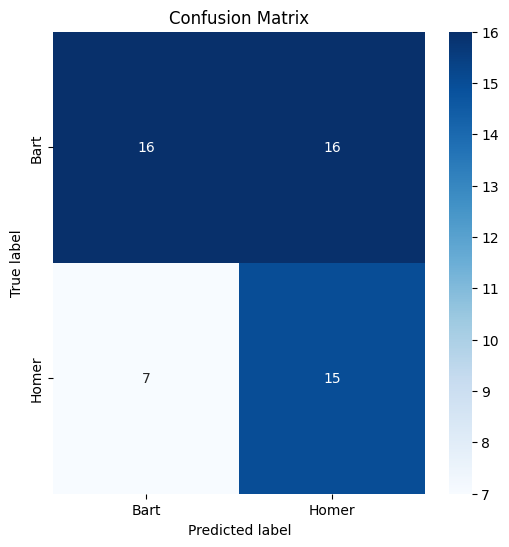

Train Epoch: 4 [0/215 (0%)]	Loss: 0.884881
Epoch 4, Loss: 0.0145, Accuracy: 62.79%

Test set: Average loss: 0.7525, Accuracy: 33/54 (61%)



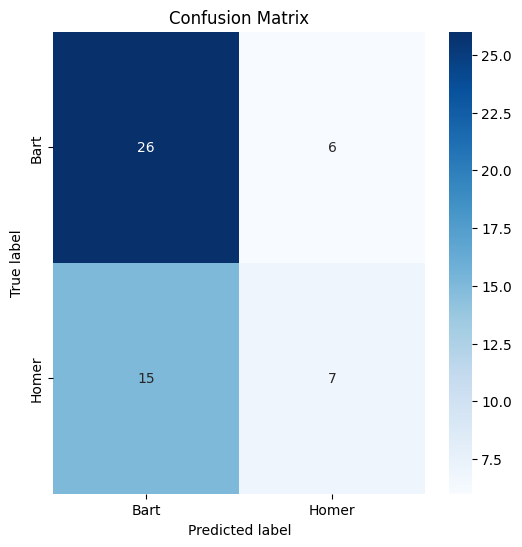

Train Epoch: 5 [0/215 (0%)]	Loss: 0.804206
Epoch 5, Loss: 0.0161, Accuracy: 63.26%

Test set: Average loss: 0.6323, Accuracy: 37/54 (69%)



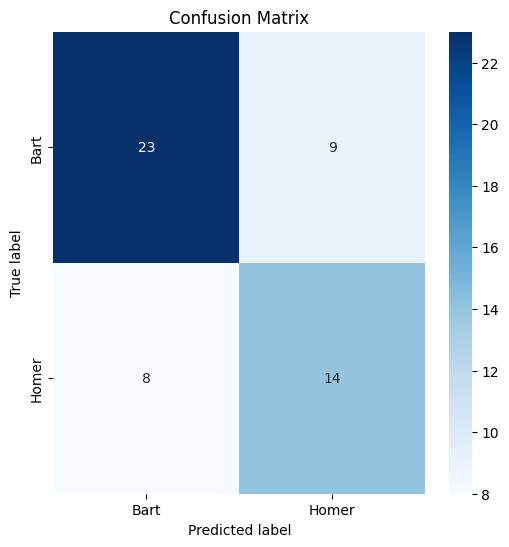

Train Epoch: 6 [0/215 (0%)]	Loss: 0.887808
Epoch 6, Loss: 0.0137, Accuracy: 59.07%

Test set: Average loss: 0.6550, Accuracy: 33/54 (61%)



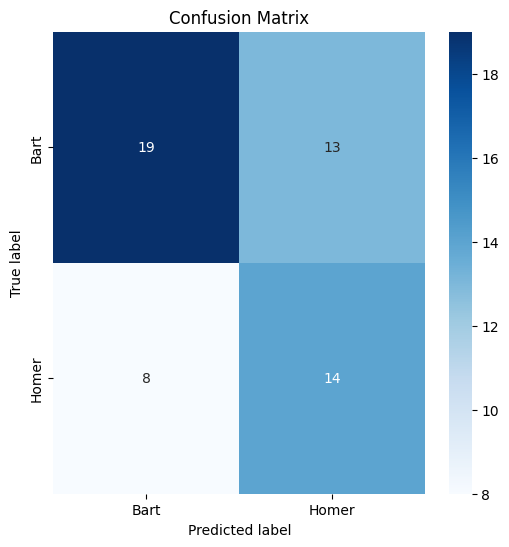

Train Epoch: 7 [0/215 (0%)]	Loss: 0.698339
Epoch 7, Loss: 0.0112, Accuracy: 68.84%

Test set: Average loss: 0.5554, Accuracy: 37/54 (69%)



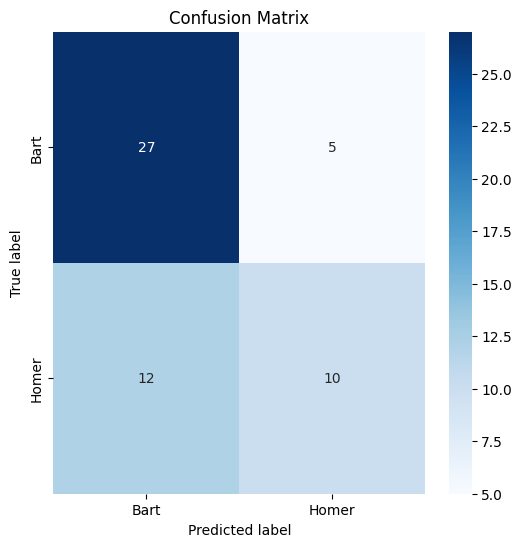

Train Epoch: 8 [0/215 (0%)]	Loss: 0.493699
Epoch 8, Loss: 0.0112, Accuracy: 69.30%

Test set: Average loss: 0.6506, Accuracy: 41/54 (76%)



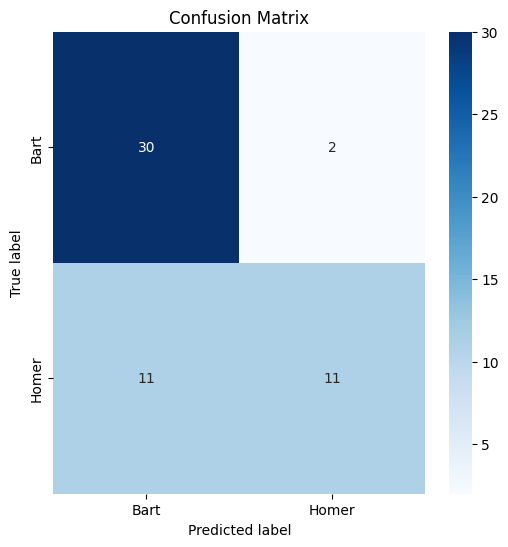

Train Epoch: 9 [0/215 (0%)]	Loss: 0.736872
Epoch 9, Loss: 0.0133, Accuracy: 64.65%

Test set: Average loss: 0.5490, Accuracy: 41/54 (76%)



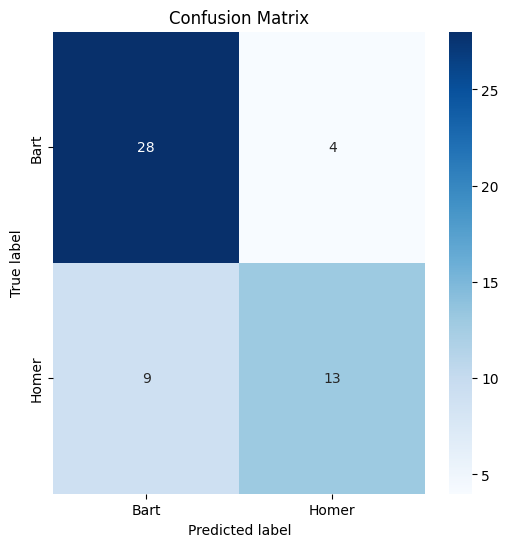

Train Epoch: 10 [0/215 (0%)]	Loss: 0.527498
Epoch 10, Loss: 0.0129, Accuracy: 65.12%

Test set: Average loss: 0.5649, Accuracy: 42/54 (78%)



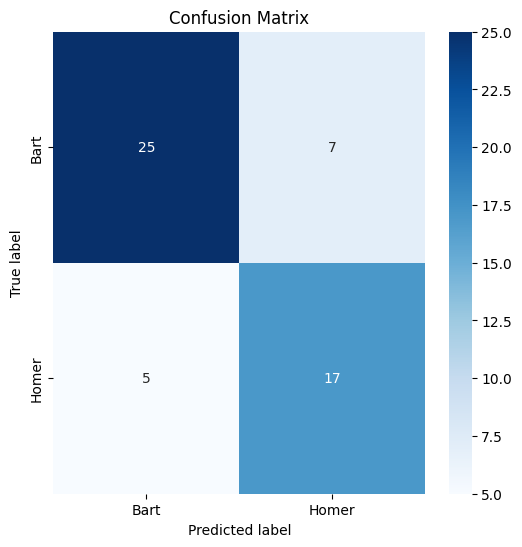

Train Epoch: 11 [0/215 (0%)]	Loss: 0.608643
Epoch 11, Loss: 0.0106, Accuracy: 68.37%

Test set: Average loss: 0.6168, Accuracy: 38/54 (70%)



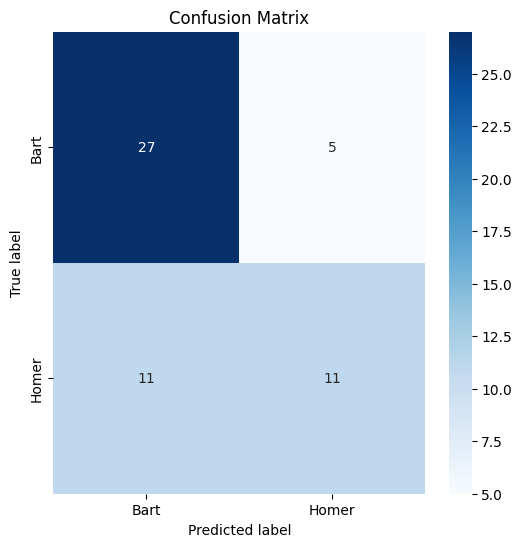

Train Epoch: 12 [0/215 (0%)]	Loss: 0.610322
Epoch 12, Loss: 0.0124, Accuracy: 68.84%

Test set: Average loss: 0.5790, Accuracy: 36/54 (67%)



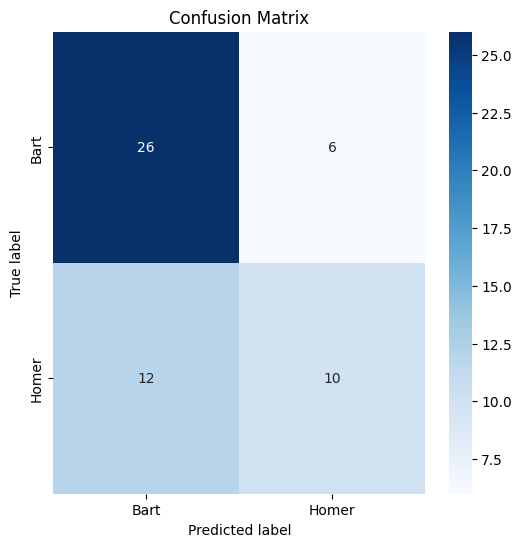

Train Epoch: 13 [0/215 (0%)]	Loss: 0.569413
Epoch 13, Loss: 0.0125, Accuracy: 66.05%

Test set: Average loss: 0.5523, Accuracy: 43/54 (80%)



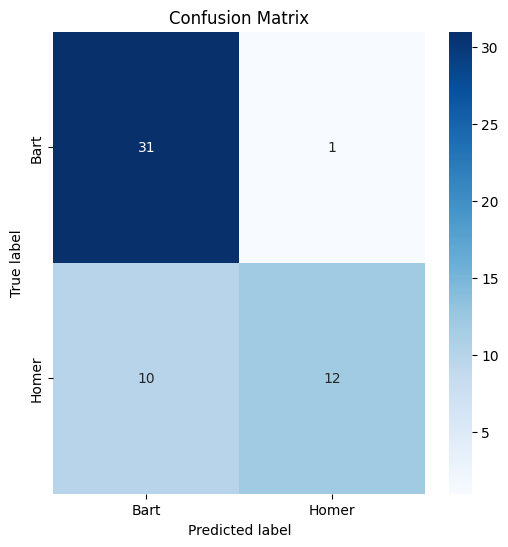

Train Epoch: 14 [0/215 (0%)]	Loss: 0.586241
Epoch 14, Loss: 0.0106, Accuracy: 73.95%

Test set: Average loss: 0.5685, Accuracy: 39/54 (72%)



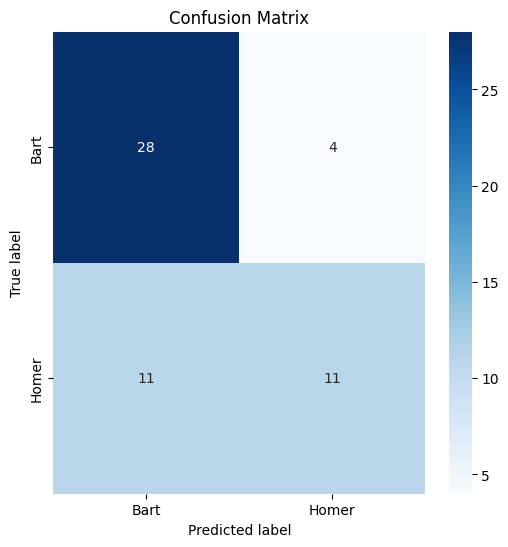

Train Epoch: 15 [0/215 (0%)]	Loss: 0.471716
Epoch 15, Loss: 0.0109, Accuracy: 71.63%

Test set: Average loss: 0.5690, Accuracy: 43/54 (80%)



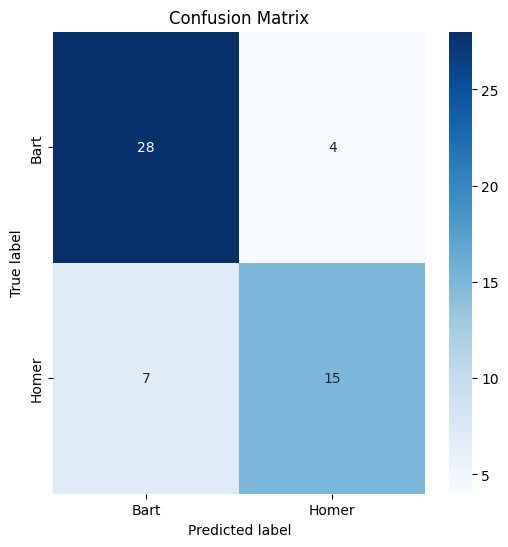

Train Epoch: 16 [0/215 (0%)]	Loss: 0.497940
Epoch 16, Loss: 0.0097, Accuracy: 76.28%

Test set: Average loss: 0.6032, Accuracy: 38/54 (70%)



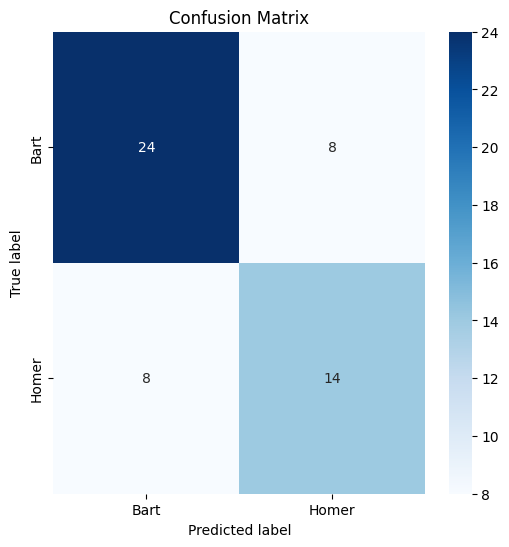

Train Epoch: 17 [0/215 (0%)]	Loss: 0.695472
Epoch 17, Loss: 0.0101, Accuracy: 73.95%

Test set: Average loss: 0.5964, Accuracy: 36/54 (67%)



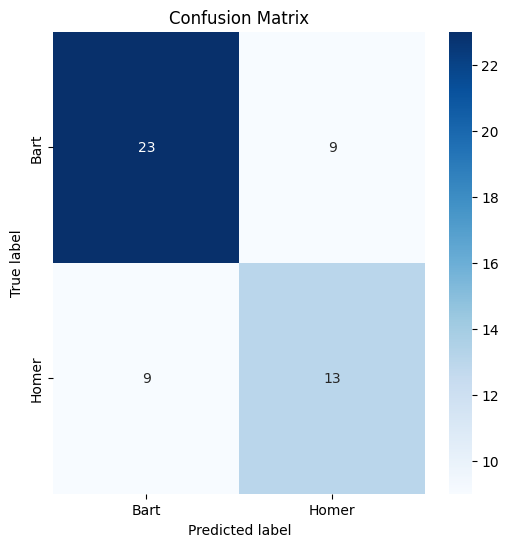

Train Epoch: 18 [0/215 (0%)]	Loss: 0.613680
Epoch 18, Loss: 0.0105, Accuracy: 70.23%

Test set: Average loss: 0.5643, Accuracy: 36/54 (67%)



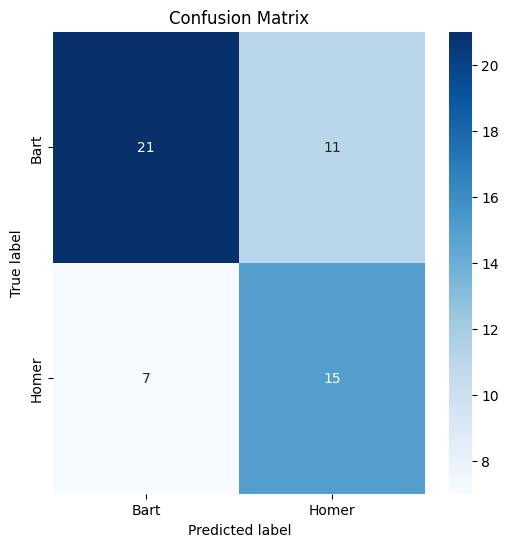

Train Epoch: 19 [0/215 (0%)]	Loss: 0.640388
Epoch 19, Loss: 0.0113, Accuracy: 61.86%

Test set: Average loss: 0.5939, Accuracy: 37/54 (69%)



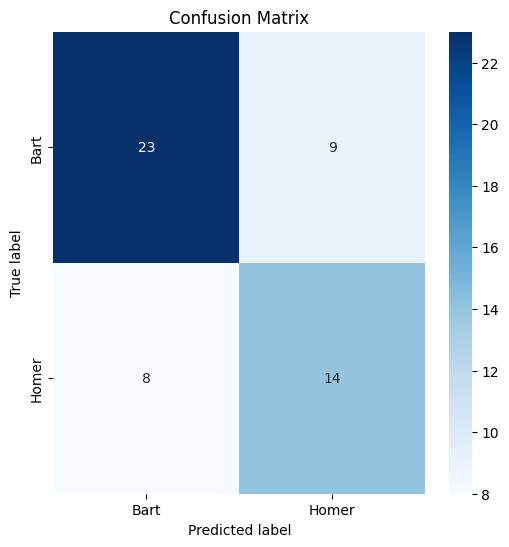

Train Epoch: 20 [0/215 (0%)]	Loss: 0.532237
Epoch 20, Loss: 0.0101, Accuracy: 72.09%

Test set: Average loss: 0.5955, Accuracy: 41/54 (76%)



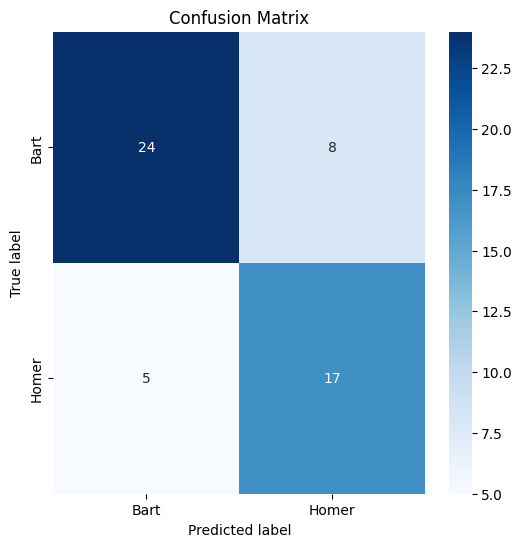

Train Epoch: 21 [0/215 (0%)]	Loss: 0.556447
Epoch 21, Loss: 0.0109, Accuracy: 69.30%

Test set: Average loss: 0.5958, Accuracy: 36/54 (67%)



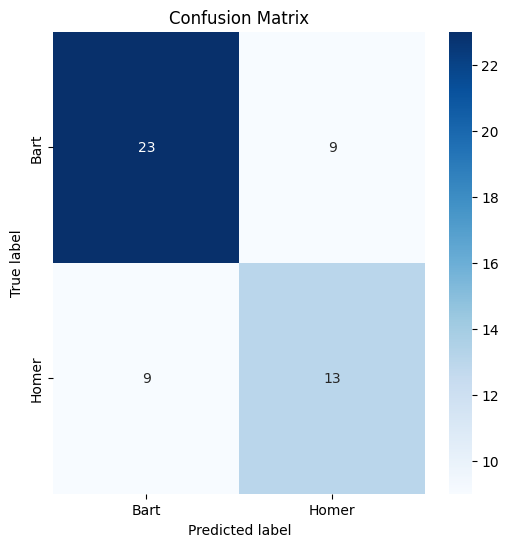

Train Epoch: 22 [0/215 (0%)]	Loss: 0.507061
Epoch 22, Loss: 0.0094, Accuracy: 69.77%

Test set: Average loss: 0.5638, Accuracy: 39/54 (72%)



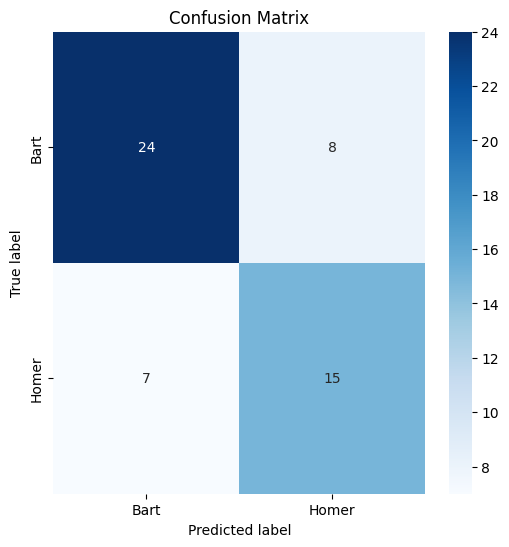

Train Epoch: 23 [0/215 (0%)]	Loss: 0.597701
Epoch 23, Loss: 0.0103, Accuracy: 71.16%

Test set: Average loss: 0.6369, Accuracy: 33/54 (61%)



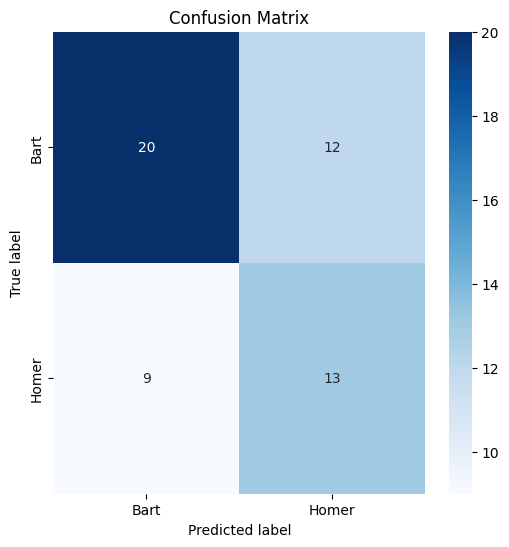

Train Epoch: 24 [0/215 (0%)]	Loss: 0.501284
Epoch 24, Loss: 0.0094, Accuracy: 71.16%

Test set: Average loss: 0.5749, Accuracy: 36/54 (67%)



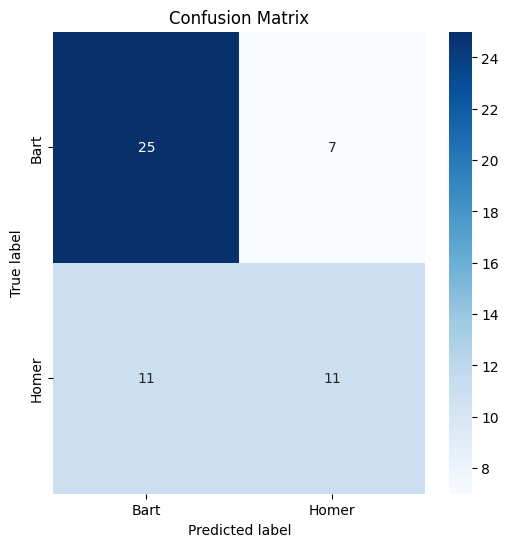

Train Epoch: 25 [0/215 (0%)]	Loss: 0.562940
Epoch 25, Loss: 0.0115, Accuracy: 69.30%

Test set: Average loss: 0.6137, Accuracy: 35/54 (65%)



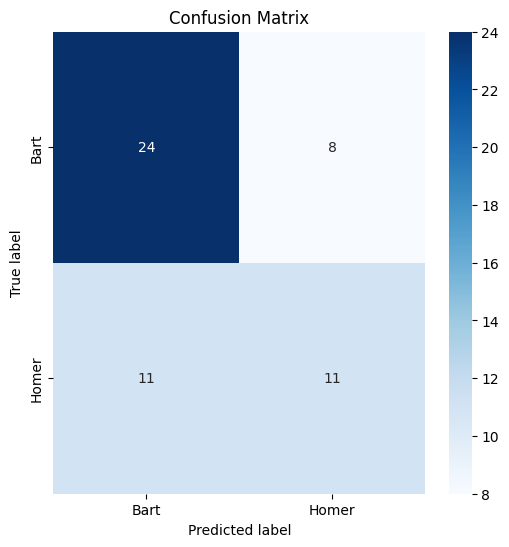

Train Epoch: 26 [0/215 (0%)]	Loss: 0.536672
Epoch 26, Loss: 0.0094, Accuracy: 75.35%

Test set: Average loss: 0.5372, Accuracy: 39/54 (72%)



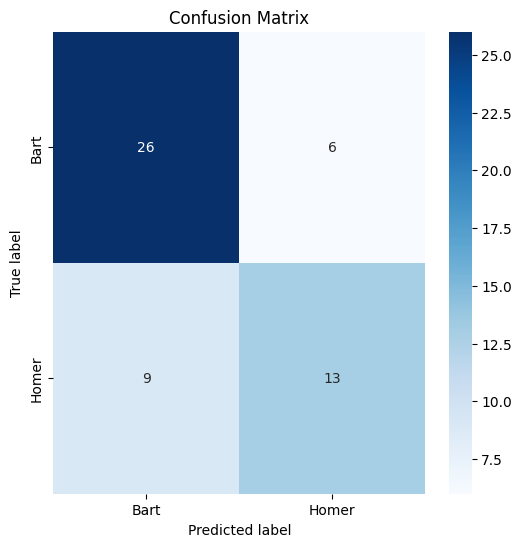

Train Epoch: 27 [0/215 (0%)]	Loss: 0.622839
Epoch 27, Loss: 0.0113, Accuracy: 68.37%

Test set: Average loss: 0.5614, Accuracy: 38/54 (70%)



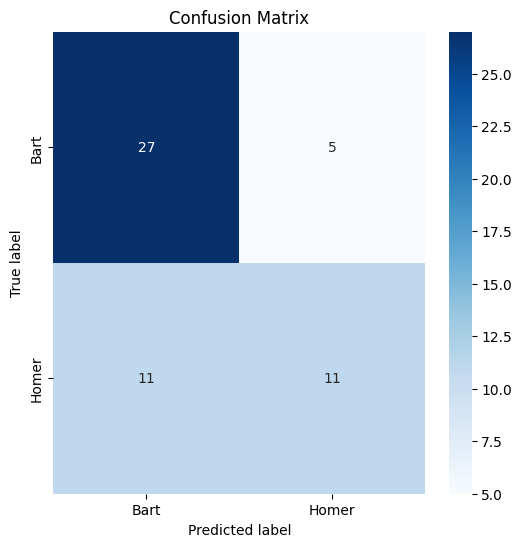

Train Epoch: 28 [0/215 (0%)]	Loss: 0.456210
Epoch 28, Loss: 0.0096, Accuracy: 74.88%

Test set: Average loss: 0.5652, Accuracy: 36/54 (67%)



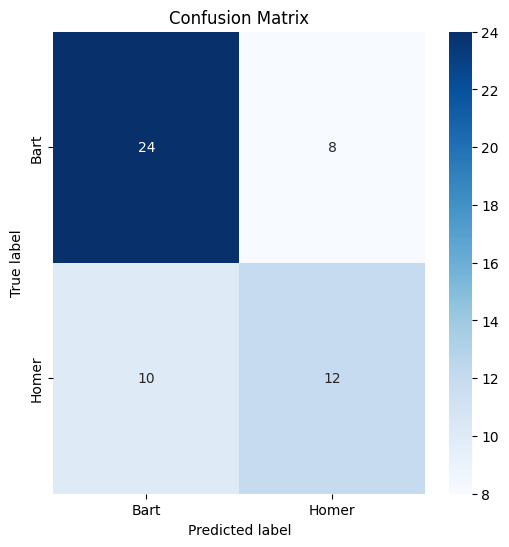

Train Epoch: 29 [0/215 (0%)]	Loss: 0.553734
Epoch 29, Loss: 0.0093, Accuracy: 72.56%

Test set: Average loss: 0.6012, Accuracy: 38/54 (70%)



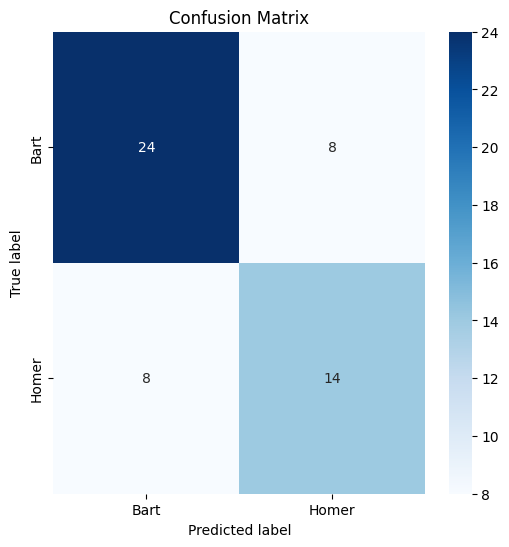

Train Epoch: 30 [0/215 (0%)]	Loss: 0.610902
Epoch 30, Loss: 0.0108, Accuracy: 67.44%

Test set: Average loss: 0.5231, Accuracy: 42/54 (78%)



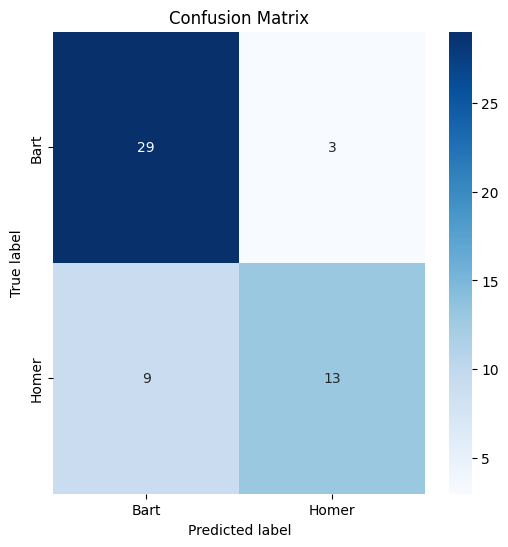

Train Epoch: 31 [0/215 (0%)]	Loss: 0.541947
Epoch 31, Loss: 0.0088, Accuracy: 74.88%

Test set: Average loss: 0.6142, Accuracy: 36/54 (67%)



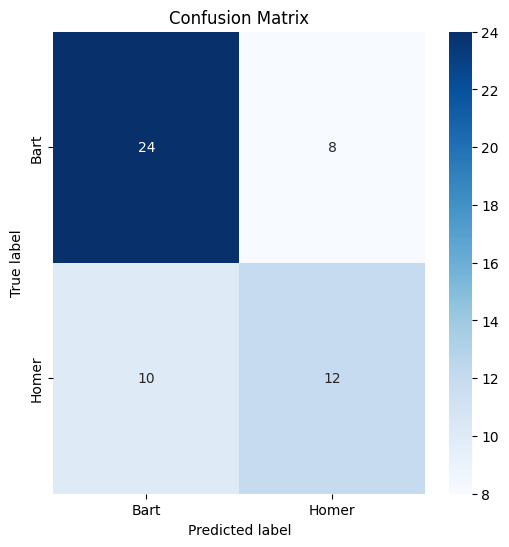

Train Epoch: 32 [0/215 (0%)]	Loss: 0.479948
Epoch 32, Loss: 0.0101, Accuracy: 71.63%

Test set: Average loss: 0.5598, Accuracy: 40/54 (74%)



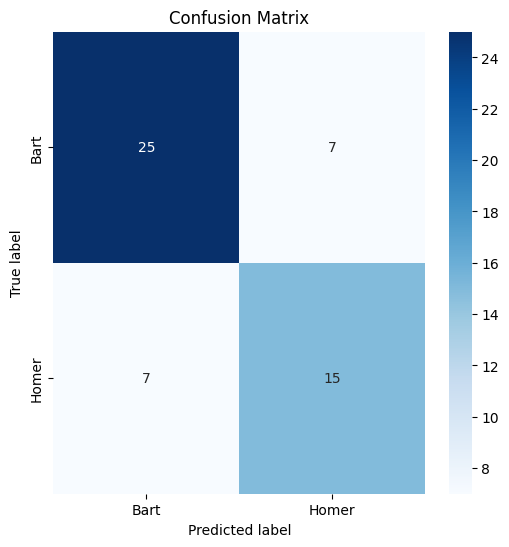

Train Epoch: 33 [0/215 (0%)]	Loss: 0.596425
Epoch 33, Loss: 0.0117, Accuracy: 64.19%

Test set: Average loss: 0.6181, Accuracy: 36/54 (67%)



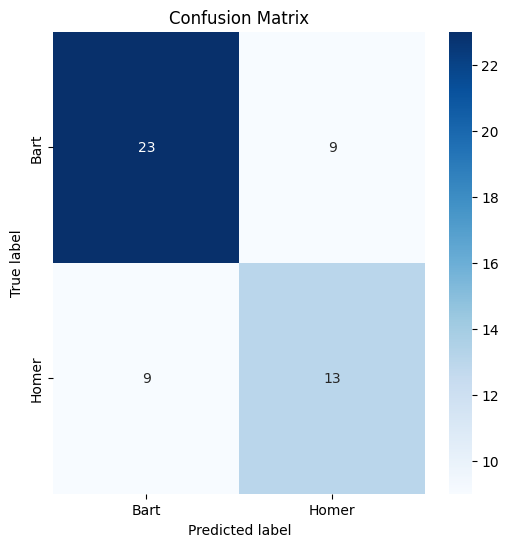

Train Epoch: 34 [0/215 (0%)]	Loss: 0.527799
Epoch 34, Loss: 0.0091, Accuracy: 72.56%

Test set: Average loss: 0.5872, Accuracy: 41/54 (76%)



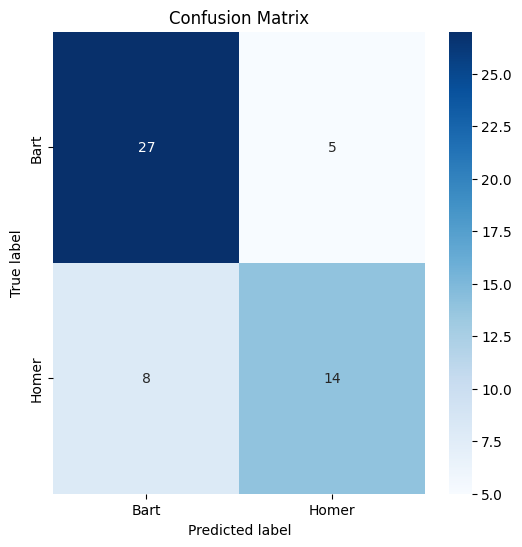

Train Epoch: 35 [0/215 (0%)]	Loss: 0.621784
Epoch 35, Loss: 0.0103, Accuracy: 69.77%

Test set: Average loss: 0.5462, Accuracy: 37/54 (69%)



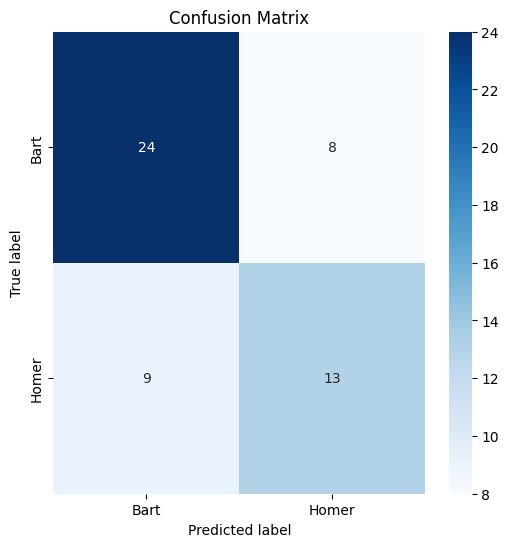

Train Epoch: 36 [0/215 (0%)]	Loss: 0.585704
Epoch 36, Loss: 0.0102, Accuracy: 71.63%

Test set: Average loss: 0.5743, Accuracy: 39/54 (72%)



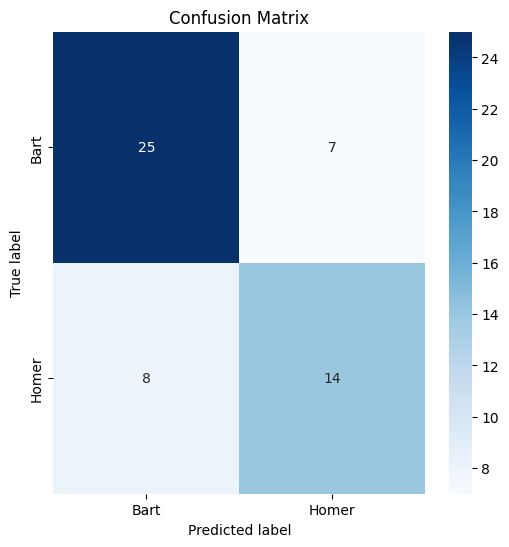

Train Epoch: 37 [0/215 (0%)]	Loss: 0.645254
Epoch 37, Loss: 0.0102, Accuracy: 72.09%

Test set: Average loss: 0.5296, Accuracy: 39/54 (72%)



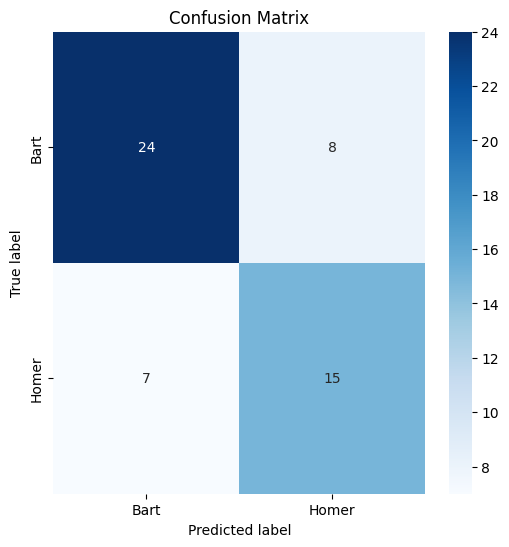

Train Epoch: 38 [0/215 (0%)]	Loss: 0.536686
Epoch 38, Loss: 0.0097, Accuracy: 73.49%

Test set: Average loss: 0.5656, Accuracy: 40/54 (74%)



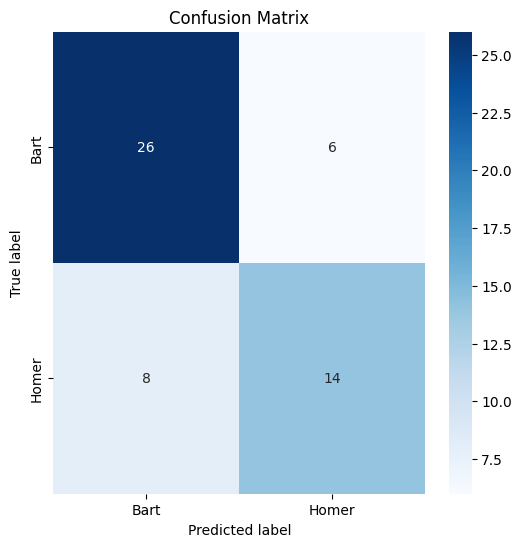

Train Epoch: 39 [0/215 (0%)]	Loss: 0.669094
Epoch 39, Loss: 0.0105, Accuracy: 76.28%

Test set: Average loss: 0.5494, Accuracy: 40/54 (74%)



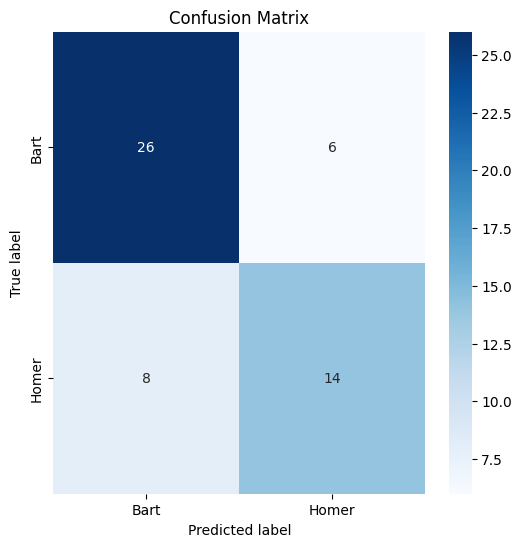

Train Epoch: 40 [0/215 (0%)]	Loss: 0.602251
Epoch 40, Loss: 0.0107, Accuracy: 67.91%

Test set: Average loss: 0.5711, Accuracy: 35/54 (65%)



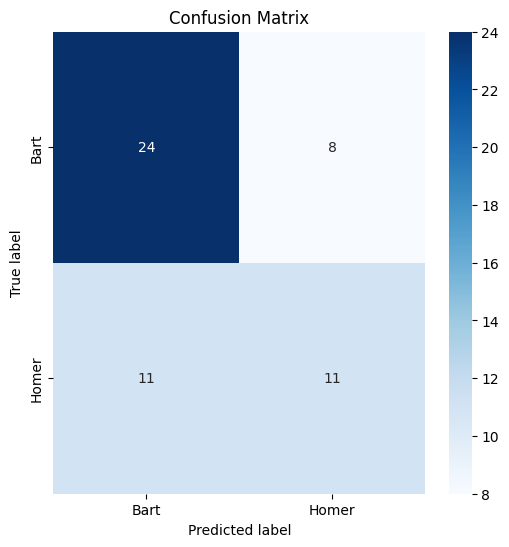

Train Epoch: 41 [0/215 (0%)]	Loss: 0.485873
Epoch 41, Loss: 0.0089, Accuracy: 80.00%

Test set: Average loss: 0.5517, Accuracy: 39/54 (72%)



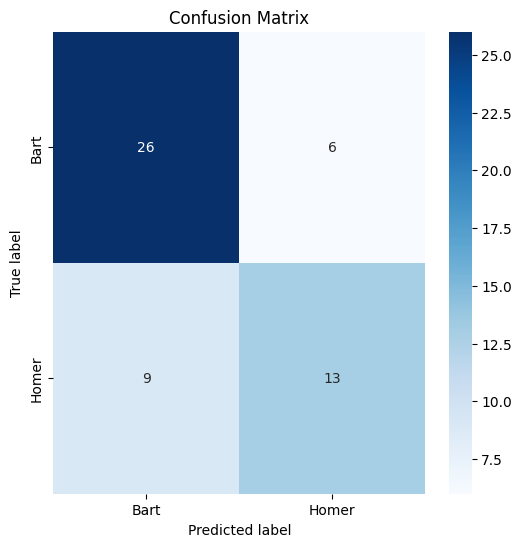

Train Epoch: 42 [0/215 (0%)]	Loss: 0.641876
Epoch 42, Loss: 0.0103, Accuracy: 69.77%

Test set: Average loss: 0.6169, Accuracy: 39/54 (72%)



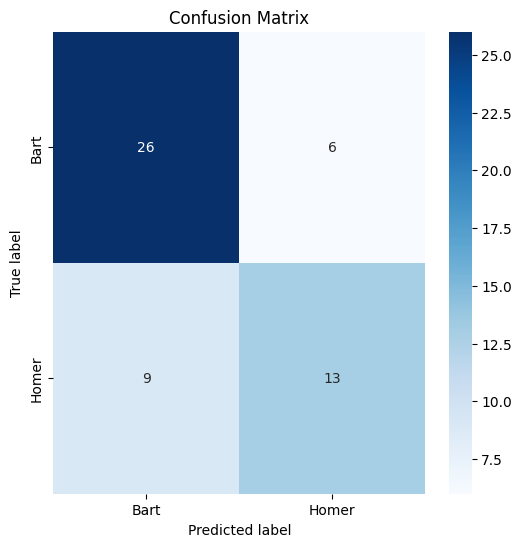

Train Epoch: 43 [0/215 (0%)]	Loss: 0.589766
Epoch 43, Loss: 0.0102, Accuracy: 70.23%

Test set: Average loss: 0.6324, Accuracy: 38/54 (70%)



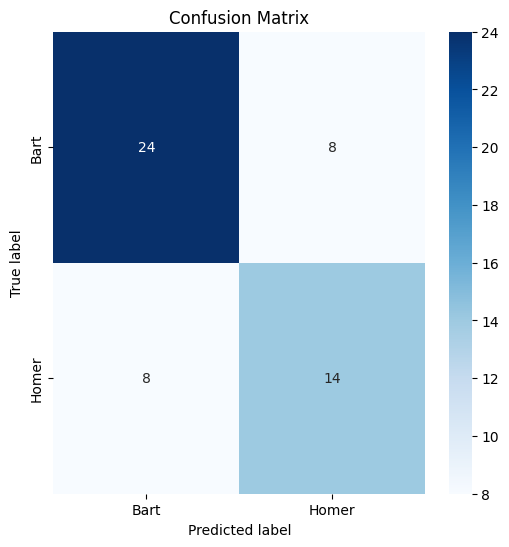

Train Epoch: 44 [0/215 (0%)]	Loss: 0.475873
Epoch 44, Loss: 0.0106, Accuracy: 72.56%

Test set: Average loss: 0.5827, Accuracy: 38/54 (70%)



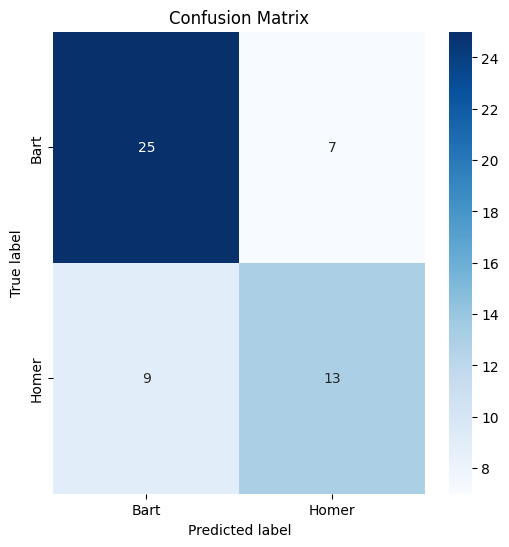

Train Epoch: 45 [0/215 (0%)]	Loss: 0.638364
Epoch 45, Loss: 0.0100, Accuracy: 72.56%

Test set: Average loss: 0.6026, Accuracy: 36/54 (67%)



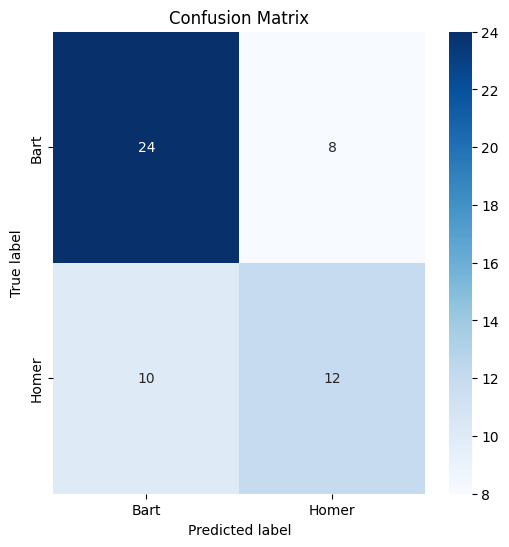

Train Epoch: 46 [0/215 (0%)]	Loss: 0.574215
Epoch 46, Loss: 0.0106, Accuracy: 72.09%

Test set: Average loss: 0.6552, Accuracy: 35/54 (65%)



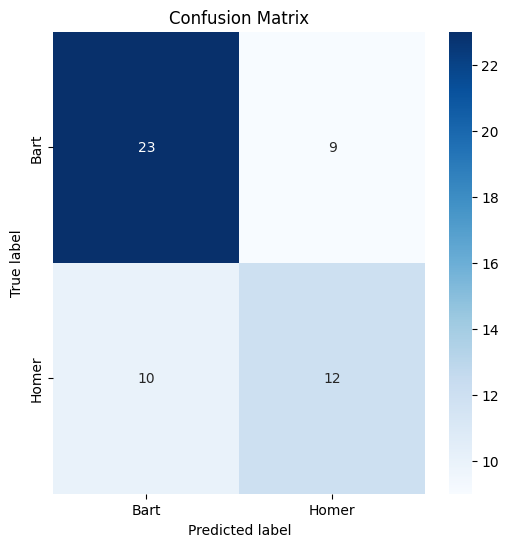

Train Epoch: 47 [0/215 (0%)]	Loss: 0.672871
Epoch 47, Loss: 0.0113, Accuracy: 66.98%

Test set: Average loss: 0.5667, Accuracy: 36/54 (67%)



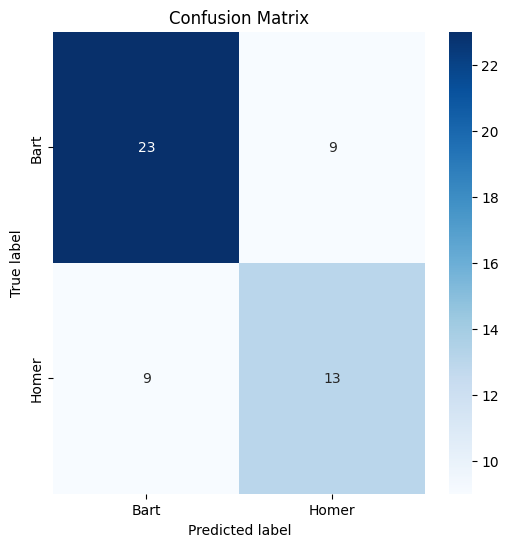

Train Epoch: 48 [0/215 (0%)]	Loss: 0.519247
Epoch 48, Loss: 0.0098, Accuracy: 73.95%

Test set: Average loss: 0.6084, Accuracy: 33/54 (61%)



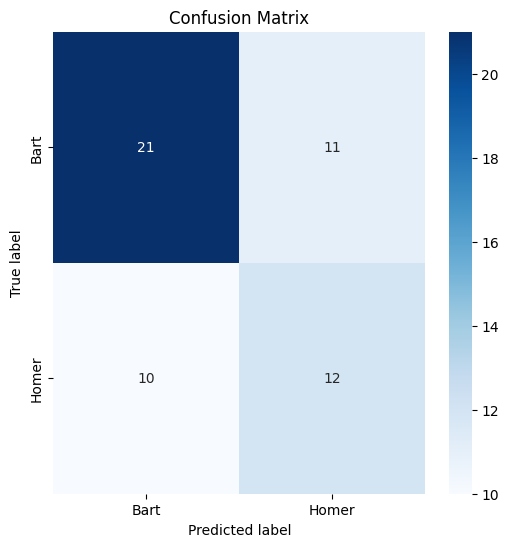

Train Epoch: 49 [0/215 (0%)]	Loss: 0.549560
Epoch 49, Loss: 0.0100, Accuracy: 74.42%

Test set: Average loss: 0.5632, Accuracy: 36/54 (67%)



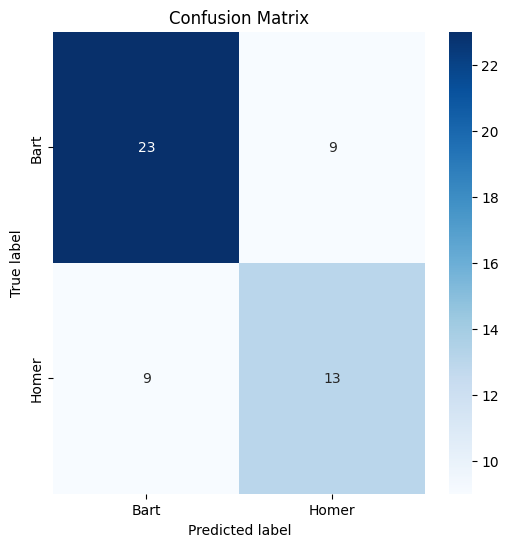

Train Epoch: 50 [0/215 (0%)]	Loss: 0.493423
Epoch 50, Loss: 0.0107, Accuracy: 70.23%

Test set: Average loss: 0.5283, Accuracy: 39/54 (72%)



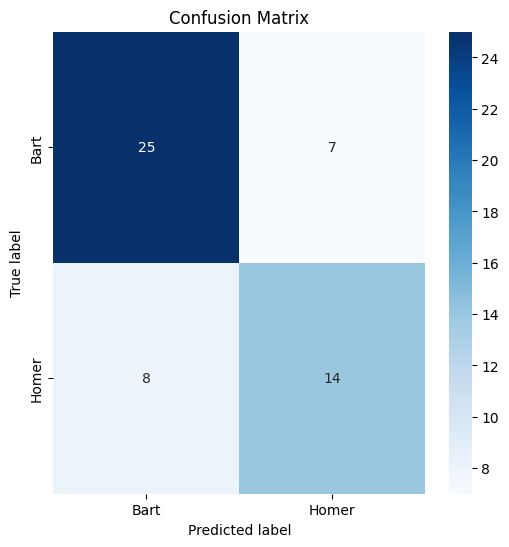

In [ ]:
# Inicializar o modelo, otimizador e scheduler
#model = Net().to(device)
model = MLP().to(device)
#optimizer = optim.Adadelta(model.parameters(), lr=1)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
#scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Treinamento e teste
epochs = 50
train_losses = []
test_accuracies = []

for epoch in range(1, epochs + 1):
    train(10, False, model, device, train_loader, optimizer, epoch)
    accuracy, test_loss = test_with_metrics(model, device, test_loader)
    train_losses.append(test_loss)
    test_accuracies.append(accuracy)
    #scheduler.step()
    scheduler.step(test_loss)



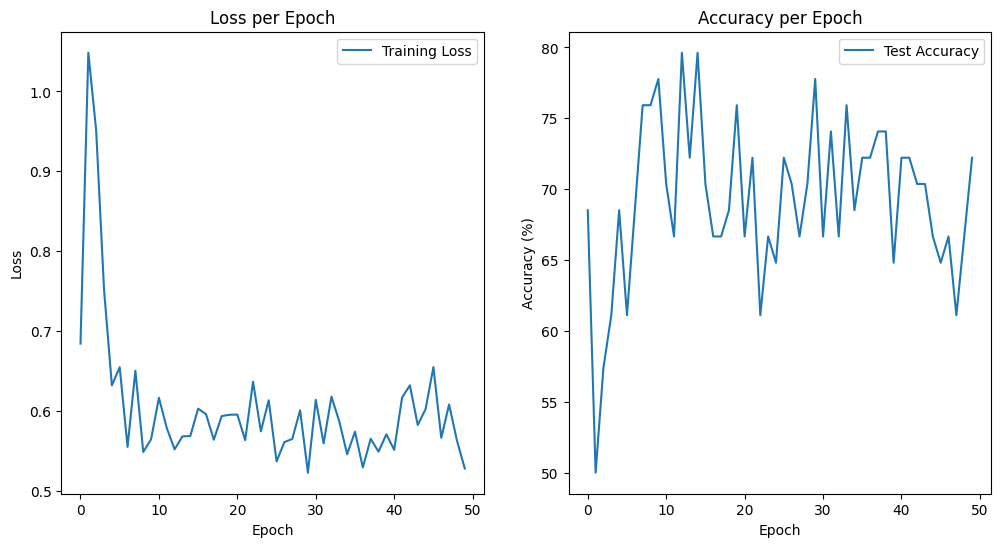

In [ ]:
# Plotando as métricas
plt.figure(figsize=(12, 6))

# Plotando a perda
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Plotando a acurácia
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

# Salvar o modelo treinado
torch.save(model.state_dict(), "homer_bart_cnn.pt")

In [ ]:
def calculate_overall_accuracy(model, device, test_loader):
    model.eval()  # Coloca o modelo em modo de avaliação
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # Índice da maior probabilidade
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    accuracy = 100. * correct / total
    return accuracy

# Calcular a acurácia global após o treinamento
final_accuracy = calculate_overall_accuracy(model, device, test_loader)
print(f"Acurácia global do modelo: {final_accuracy:.2f}%")


Acurácia global do modelo: 74.07%


## Aprendizados

- Uso do módulo torchvision.transforms para pré-processar imagens
- Maior desenvolvimento com o pytorch (novos comandos)
- Maior contato com a CPU ( problemas que deram e ter mais noção do tamanho do que se está trabalhando)
